# **Using the Grey Wolf Metaheuristic Optimization Algorithm to Solve a Game of Battleship**

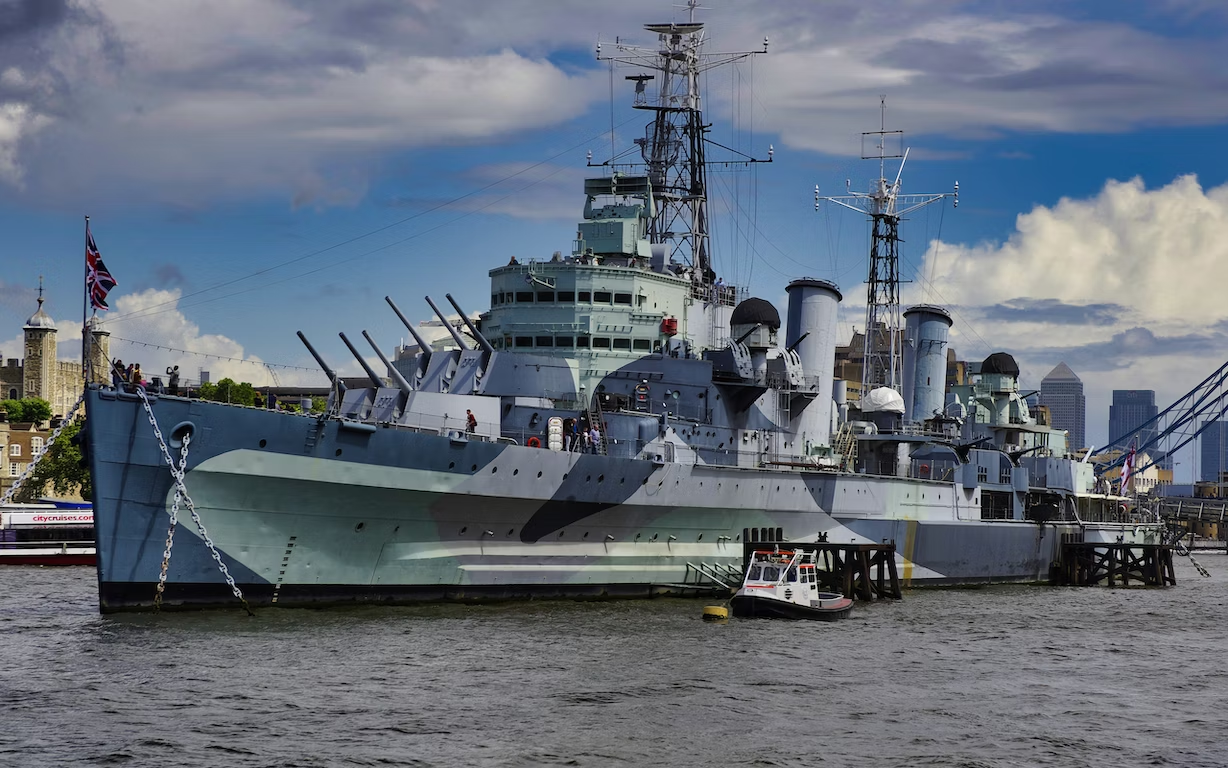
Source: Unsplash

This program uses the concept of a metaheuristic which relies on stochastic optimization to reach a global optima. A solution is not guaranteed however compared to combinatorial optimization, the process is a lot faster using lesser computational resources.

The particular algorithm used in this program is the Grey Wolf Optimizer (GWO) which mimics the hunting patterns of grey wolves through mathmematical models and maps movement using vector positioning.

This implementation is done using python and stochastic features rely on the random library.

GWO: https://www.sciencedirect.com/science/article/abs/pii/S0965997813001853



In [2]:
#import statements

#random library for stochasitc features
from random import randint as rd_int
from random import randrange as rd_rg
from random import random as rd

#other libraries used throughout the project
import numpy as np
import pandas as pd
import copy
import math

## **Setting Up the Board**

To simulate the game of Battleship, we have a custom function defined as new_board() which creates a 10x10 array of 1's and 0's. Here the 1's represent a part of a ship and 0's represent an ocean cell. 

The ships we are using are of the lengths 2, 3, 3, 4, and 5, with a special constraint that they can be in any shape as long the individual 1's representing the ship are in one continuous chain. 

> For example, a ship can look like this:

```
[0,0,1,0,0,0,...]
[0,0,1,1,0,0,...]
[0,0,0,1,0,0,...]
.
.
```
> but not like this:

```
[0,0,1,0,0,0,...]
[0,0,0,1,0,0,...]
[0,0,0,0,1,0,...]
.
.
```
> A byproduct of this method is that multiple ships grouped together can form a larger cluster of 1's like this:

```
[0,0,1,1,1,0,...]
[0,0,1,1,0,0,...]
[1,1,1,1,0,0,...]
.
.

```
> (An example of a 3 ship, a 2 ship and a 4 ship clustered together)

The positions of the 1's themselves is generated through a random coordinate with x and y values between 0 and 9, making the 10x10 board a representation of the cartesian plane.

The process of generating a new board is roughly as follows:


1. Create 10x10 array
2. Generate a random coordinate in a 10x10 plane (0 to 9 on each axis)
3. Check if that coordinate already has a ship piece, if not place otherwise generate new coordinate
4. Once the first part of a ship of length n is placed, for the remianing n-1 pieces, they are placed adjacent to the last piece placed i.e. +-1 on either the x-coordinate or the y-coordinate
5. Once all n pieces are placed, move to the next ship to be placed and repeat steps 2 through 4
6. Due to some edge cases, check is the total number of 1's placed is equal to the sum of the total ships to be placed (17 here) and if not, repeat the entire process (This will rarely happen)
7. Return the board array generated with all the 1's placed and the list of solution coordinates

In [52]:
#this method creates a new battleship board represented as a 2D array where the
#1s are locations of a ship and 0s represents ocean cell
def new_board():

    #we will use a 10x10 grid for this game
    board = np.array([[0 for i in range(10)] for i in range(10)]) #creating default 2D array of 10 rows of 0s

    ship_coords = []    #coordinates of existing ship pieces
    ship_len_avail = [2, 3, 3, 4, 5] #using standard ship lengths as 2, 3, 3, 4, 5

    #loops through each available ship length
    for i in ship_len_avail:
        first_flag = True   #checks if this is the first piece of the ship

        #for loop to add appropriate number of ship pieces acc to current length
        for j in range(i): 
            new_piece_flag = True   #check to see if a piece exists same as the new random piece generated
            while new_piece_flag:

                #first piece of ship can be placed anywhere
                if (first_flag):

                    #setting random values on 10x10 board for first ship piece
                    x_coord = rd_int(0, 9)
                    y_coord = rd_int(0, 9)

                #anything after first piece can only be placed adjacent to the first piece
                else:   

                    #if the random generator outputs 0 then x coordinate gets changed
                    if(rd_int(0,1) == 0):  
                        
                        #+- 1 randomly to x coord
                        if (x_coord < 9):
                            x_coord = abs(x_coord + rd_rg(-1,2,2))    
                        
                        #edge case to prevent index out of bounds
                        else:   
                            x_coord = x_coord - 1

                    #else the y coordinate is changed 
                    else:   

                        #+- 1 randomly to y coord
                        if (y_coord < 9):
                            y_coord = abs(y_coord + rd_rg(-1,2,2))   

                        #edge case to prevent index out of bounds
                        else:   
                            y_coord = y_coord - 1 
                        
                #if the new x,y does not already have a ship piece, exit out of the while loop
                if((x_coord, abs(9-y_coord)) not in ship_coords):  
                    if(first_flag):
                        first_flag = False #as first piece has been added, switching flag
                    
                    new_piece_flag = False #exit ship placement loop as current coord is a non-duplicate

            board[y_coord][x_coord] = 1 #next adjacent piece to last current piece
            curr_piece = (x_coord, abs(9-y_coord)) #storing current piece
            ship_coords.append(curr_piece)  #storing to all current ship pieces
            
    #edge case for unfeasible ships, method is called again
    if(len(ship_coords) != sum(ship_len_avail)):
        new_board()
    
    return board, ship_coords

## **Checking Accuracy of Shot**

To check the accuracy of a shot we use the accuracy() function which takes two arguments, the coordinates of the shot itself and the list of all solution coordinates. We then take **the *L2 Norm (or Euclidean Distance) between the shot coordinate and each one of the solution coordinates**. Sorting these distances in ascending order gives us the first element being the closest ship to a shot, with the ideal scenario being a distance of 0.0 indicating a shot has hit a ship. Once a ship has been hit, it is removed from the list of solution coordinates (sol_check in this case) and the function returns the smallest distance to a ship coordinate

\

***L2 Norm/ Euclidean Distance:**

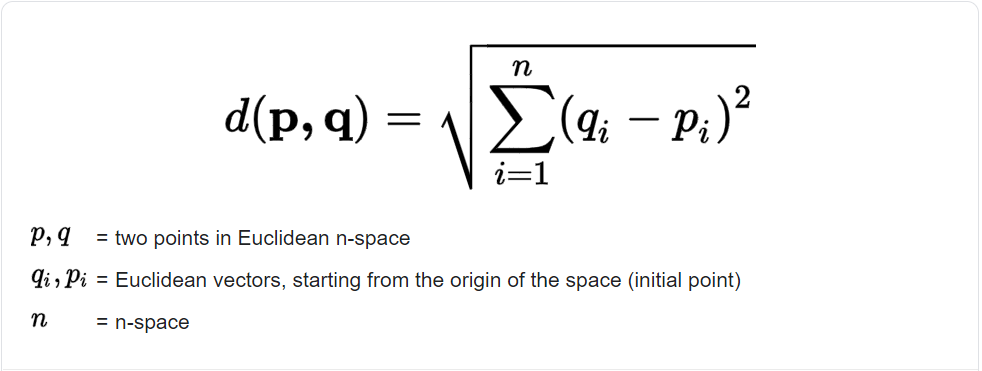

Source: Google Images

In [77]:
#this method determines the accuracy of a shot (distance between current location and closest ship)
#value is the norm of the distance between the two points
def accuracy(shot, sol_check):

    #calculating distance (L2 Norm) to each ship piece and adding to distances list
    for i in (sol_check):
        curr_dist = np.linalg.norm(np.array(shot)-np.array(i))

        #max distance will not exceed 20 
        if(curr_dist < 20.0):
            min_dist = curr_dist
            min_coord = i

    #returns distance to closest ship piece
    return min_dist

## **Metaheuristic Optimization Implementation**

The way this program solves the game of battleship is through the implementation of a Metaheuristic Optimization Algorithm, more specifcally, the Grey Wolf Optimizer.

This is based on a research paper by Seyedali Mirjalili documenting the translation of Grey Wolf hunting patterns to a Metaheuristic. Through emulating nature, this algorithm is able to track down a prey (solution) without getting stuck in a local optima i.e. the point of a metaheuristic.

Though Metaheuristics are generally not viewed as the most optimal tools approaching problems with a lot of nuance or large-scale complexities, the aim of this particular implementation is to see the capabilities of the algorithm. 

> The benefits of using Metaheuristics in such an implementation are as follows:

1. Problem-agnostic, hence we can mold the algorithm to suit our needs such as solving a game of battleship
2. Able to find a sufficient solution without necessarily finding the global optima which saves time and computing resources as compared to an exponential exhaustive search
3. Use stochastic means to avoid local minima
4. Gives us an insight into nature and how mimicking nature can provide useful computational results

Understanding this, the Grey Wolf optimizer implements mathematical formulae to mirror wolf positioning and attack patterns using vector positioning and two phases- exploration and exploitation. This is done through understanding how herd mentality works in a hunt the natural heirarchy within Grey Wolves i.e. Alpha, Beta, Delta, etc.

> More on the specifics of the algorithm can be found here: https://www.sciencedirect.com/science/article/abs/pii/S0965997813001853

In this implementation, we initiate all three wolf categories to a starting position of (0,0) and through random placement of a set pack size (in this case 5 wolves in a pack), wolves across aforementioned three categories are scattered and their accuracy is determined by how close their positioning in the XY plane is to a ship coordinate i.e. 1 in a sea of 0's. The distances are all ordered in an ascending fashion and the lowest value (closest wolf) is deemed the Alpha while the second closest is the Beta and the remaining are deemed Deltas. 

> An example of 5 wolves being generated in the categories of Alpha, Beta and Delta:

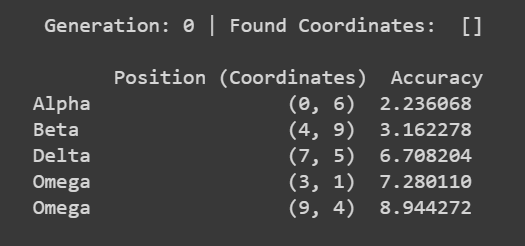

The Alpha and Beta wolves are kept and the Delta are all discarded in favor of three new positions randomly generated based on the coordinates of the Alpha and the Beta, therefore new wolves generated can only improve on the Alpha and the Beta. Once a wolf reaches a closer position than an Alpha or Beta to a ship coordinate, it replaces the Alpha or Beta and the worse wolf either shifts to become Beta or is discarded as it is now classified as a Delta. This process continues for each new Delta created (3 in our case). Once an Alpha reaches a distance of 0.0 to a ship coordinate, a ship coordinate is "found" and is removed from the list of possible solutions. This is recursively repeated until every single ship position is found and the number of generations it takes to get there is recorded.

> Example of Inter-generational change in Alpha, Beta and Delta Wolf positioning:

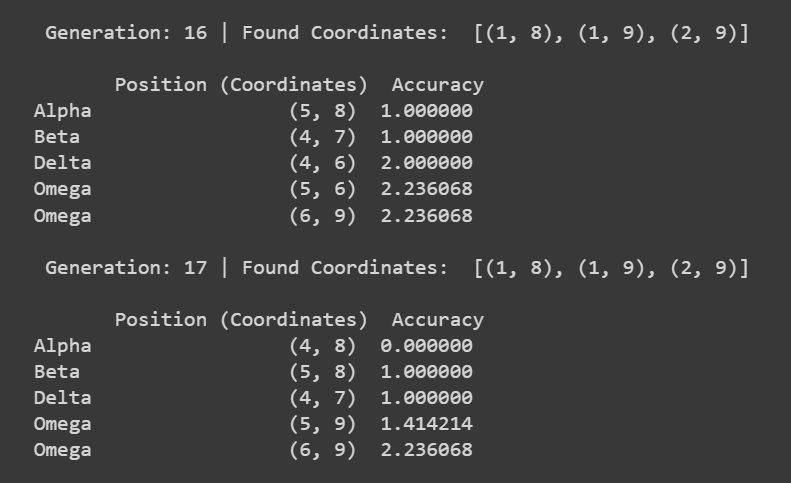

In [78]:
#wolf random position generator function
def wolf():
    x_coord = rd_int(0,9)
    y_coord = rd_int(0,9)

    return (x_coord, y_coord)

#helper function to find difference between vectors
def vec_diff(a, b):
    return (abs(a[0] - b[0]), abs(a[1]-b[1]))

#helper function to multiple int to a coordinate (tuple)
def multiply_coord(a, b):
    return (a*b[0], a*b[1])

#grey wolf optimizer
def gwo(sol_board, sol_coords, sol_check, found_coords, wolves, gen_counter, a_wolf, b_wolf, d_wolf):
    #sol_board: board with places ships
    #sol_coords: list of coordinates (solutions)
    #sol_check: temporary list of solution coordiantes to determine closest wolf (see accuracy function)
    #found_coords: list of all found coordinates through GWO
    #wolves: dictionary that contains wolf coordinates and their corresponding accuracy
    #gen_counter: counter of current wolf generation
    #a_wolf, b_wolf, d_wolf: current coordinate values for each wolf, initially (0,0) for each

    #for very first iteration of wolves
    if (len(wolves) == 0):
        for i in range(5):  #we will use 5 wolves for this algorithm's purpose
            dup_flag = True #used to check whether new_wolf created is uniques from all past wolves in this iteration

            while (dup_flag):
                new_wolf = wolf()   #generating random coordinate for new_wolf

                #if new_wolf is unique, add the wolf as a key and value being its accuracy
                if (new_wolf not in wolves.keys()):
                    wolves.update({new_wolf: accuracy(new_wolf, sol_check)})
                    dup_flag = False

    else:
        #main algorithm
        curr_iter = 0
        while curr_iter < 10:
            a = 2*(1 - curr_iter/100)   #initialting value of a which is linearly decereased from 2 to 0

            #for 5 wolves
            for i in range(5):
                #main grey wolf algorithm according to the literature 
                A1, A2, A3 = a * (2 * rd() - 1), a * (2 * rd() - 1), a * (2 * rd() - 1)
                C1, C2, C3 = 2 * rd(), 2 * rd(), 2 * rd()

                X1 = vec_diff(a_wolf, multiply_coord(A1, vec_diff(multiply_coord(C1, a_wolf), list(wolves)[i])))
                X2 = vec_diff(b_wolf, multiply_coord(A2, vec_diff(multiply_coord(C2, b_wolf), list(wolves)[i])))
                X3 = vec_diff(d_wolf, multiply_coord(A3, vec_diff(multiply_coord(C3, d_wolf), list(wolves)[i])))
                
                #finding mean of three position vectors to find new position for wolf, will round up or down as coordinates must be integers
                new_wolf = (int((X1[0] + X2[0] + X3[0])/3), int((X1[1] + X2[1] + X3[1])/3))

                #if the new wolf generated has a better accuracy than a wolf in the current generation
                #it gets replaced as long as that position is not already occupied
                if (accuracy(new_wolf, sol_check) < list(wolves.values())[i] and new_wolf not in list(wolves)):
                    wolves.pop(list(wolves)[i])
                    wolves.update({new_wolf: accuracy(new_wolf, sol_check)})

            #next iteration for while loop 
            curr_iter += 1

    wolves = dict(sorted(wolves.items(), key = lambda wolf: wolf[1]))  #sorting wolves by accuracy
    a_wolf, b_wolf, d_wolf = list(wolves)[:3]   #top three accurate wolves get assigned alpha, beta and delta respectively

    #print statements for current generation and found coordinates
    print("\n Generation:", gen_counter, "| Found Coordinates: ", sorted(found_coords))

    #formatting generation in pandas dataframe and printing it
    d = {'Position (Coordinates)': pd.Series(wolves.keys(), 
                                             index= ['Alpha', 'Beta', 'Delta', 'Omega', 'Omega']), 'Accuracy': wolves.values()}
    df = pd.DataFrame(data=d)

    print("\n", df)

    gen_counter+=1  #adding 1 to the generation counter

    #progression cases for the algorithm
    if(len(found_coords) < len(sol_coords)):
        #for when a ship piece is found
        if(math.floor(list(wolves.values())[0]) == 0):
            wolves = {} #reset wolves

            found_coords.append(a_wolf) #ship piece coords get added to found coordinates
            sol_board[abs(a_wolf[1] - 9)][a_wolf[0]] = 0 #ship piece gets removed
            sol_check.remove(a_wolf)    #removing the coordinate as a ship solution

        #ends recursion once no more solutions are available
        if (len(sol_check) == 0):
            print("\nFound all!")
            print("Found Coordinates:", sorted(found_coords))    #found solution coords printed
            print("Solution:\t", " ", sorted(sol_coords))   #original solution coords printed

            return  #stop recursion

        #for when a ship is not found however alpha wolf is getting closer
        gwo(sol_board, sol_coords, sol_check, found_coords, wolves, gen_counter, a_wolf, b_wolf, d_wolf)   #restart gwo algorithm

## **Final Output**

Using the Grey Wolf function defined above we are able to apply it to the board generating function defined earlier in this file to finally see it in action. This is an ease of use function to test the algorithm's ability to reproduce results and to analyze any differences that may show up between individual runs. First the solution board is printed for the end-user's convenience and then every generation is printed with the progress the algorithm has made i.e. the solution coordinates it has found.

> In the case all of the solution coordinates are found, the game concludes with a comparison of found coordinates and the original solution coordinates from the board itself. If successful, these will be identitcal.

In [79]:
#function to start create a new board of battleship, reset all necessary variables and run the GWO algorithm on the new board
def new_game():
    sol_board, sol_coords = new_board() #generating a solution board and solution coordinates
    sol_check = copy.copy(sol_coords)   #temp solution coords for accuracy() function, using copy library as sol_check will be altered

    print("Solution Board: \n", sol_board)

    #setting found_coords, wolves dictionary, gen_counter and each wolf's position to initial values
    gwo(sol_board, sol_coords, sol_check, [], {}, 0, (0,0), (0,0), (0,0))
    
new_game()

Solution Board: 
 [[0 1 1 0 1 1 0 0 1 1]
 [0 1 1 1 1 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

 Generation: 0 | Found Coordinates:  []

       Position (Coordinates)  Accuracy
Alpha                 (0, 6)  2.236068
Beta                  (4, 9)  3.162278
Delta                 (7, 5)  6.708204
Omega                 (3, 1)  7.280110
Omega                 (9, 4)  8.944272

 Generation: 1 | Found Coordinates:  []

       Position (Coordinates)  Accuracy
Alpha                 (2, 8)  1.000000
Beta                  (2, 7)  1.414214
Delta                 (0, 6)  2.236068
Omega                 (2, 6)  2.236068
Omega                 (3, 9)  2.236068

 Generation: 2 | Found Coordinates:  []

       Position (Coordinates)  Accuracy
Alpha                 (1, 8)  0.000000
Beta                  (2, 8)  1.000000
Delta                 (1, 7)  1.00000